In [ ]:
!unzip /content/drive/MyDrive/ColumnDet/labels_my-project-name_2021-11-10-09-12-05.zip -d /content/drive/MyDrive/ColumnDet/labels/

Archive:  /content/drive/MyDrive/ColumnDet/labels_my-project-name_2021-11-10-09-12-05.zip
 extracting: /content/drive/MyDrive/ColumnDet/labels/00060_0.xml  
 extracting: /content/drive/MyDrive/ColumnDet/labels/00060_1.xml  
 extracting: /content/drive/MyDrive/ColumnDet/labels/00060__0.xml  
 extracting: /content/drive/MyDrive/ColumnDet/labels/00060__1.xml  
 extracting: /content/drive/MyDrive/ColumnDet/labels/00061_0.xml  
 extracting: /content/drive/MyDrive/ColumnDet/labels/00061_1.xml  
 extracting: /content/drive/MyDrive/ColumnDet/labels/00061__0.xml  
 extracting: /content/drive/MyDrive/ColumnDet/labels/00061__1.xml  
 extracting: /content/drive/MyDrive/ColumnDet/labels/00070_0.xml  
 extracting: /content/drive/MyDrive/ColumnDet/labels/00070_1.xml  
 extracting: /content/drive/MyDrive/ColumnDet/labels/00070__0.xml  
 extracting: /content/drive/MyDrive/ColumnDet/labels/00070__1.xml  
 extracting: /content/drive/MyDrive/ColumnDet/labels/00071_0.xml  
 extracting: /content/drive/MyDri

In [ ]:
!touch /content/drive/MyDrive/ColumnDet/train.txt /content/drive/MyDrive/ColumnDet/test.txt /content/drive/MyDrive/ColumnDet/val.txt

In [ ]:
import os
import random

files = os.listdir('/content/drive/MyDrive/ColumnDet/labels')
random.shuffle(files)

with open('/content/drive/MyDrive/ColumnDet/train.txt', mode='w') as f:
    for item in files[:70]:
        f.writelines(item.split('.')[0]+'.png\n')

with open('/content/drive/MyDrive/ColumnDet/test.txt', mode='w') as f:
    for item in files[60:70]:
        f.writelines(item.split('.')[0]+'.png\n')

with open('/content/drive/MyDrive/ColumnDet/val.txt', mode='w') as f:
    for item in files[70::]:
        f.writelines(item.split('.')[0]+'.png\n')

In [ ]:
import os
import glob
import pandas as pd
import xml.etree.ElementTree as ET

base_path = '/content/drive/MyDrive/ColumnDet/'
anno_path = os.path.join(base_path, "labels/")
classes_names = []
xml_list = []
print(anno_path)
for xml_file in glob.glob(anno_path + "/*.xml"):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    for member in root.findall("object"):
        classes_names.append(member[0].text)
classes_names = list(set(classes_names))
classes_names.sort()
classes_names

/content/drive/MyDrive/ColumnDet/labels/


['column']

In [ ]:
import sys
import os
import json
import xml.etree.ElementTree as ET
import glob

START_BOUNDING_BOX_ID = 1
PRE_DEFINE_CATEGORIES = None
# If necessary, pre-define category and its id
#  PRE_DEFINE_CATEGORIES = {"aeroplane": 1, "bicycle": 2, "bird": 3, "boat": 4,
#  "bottle":5, "bus": 6, "car": 7, "cat": 8, "chair": 9,
#  "cow": 10, "diningtable": 11, "dog": 12, "horse": 13,
#  "motorbike": 14, "person": 15, "pottedplant": 16,
#  "sheep": 17, "sofa": 18, "train": 19, "tvmonitor": 20}


def get(root, name):
    vars = root.findall(name)
    return vars


def get_and_check(root, name, length):
    vars = root.findall(name)
    if len(vars) == 0:
        raise ValueError("Can not find %s in %s." % (name, root.tag))
    if length > 0 and len(vars) != length:
        raise ValueError(
            "The size of %s is supposed to be %d, but is %d."
            % (name, length, len(vars))
        )
    if length == 1:
        vars = vars[0]
    return vars


def get_filename_as_int(filename):
    try:
        filename = filename.replace("\\", "/").replace('page','')
        filename = os.path.splitext(os.path.basename(filename))[0]
        return int(filename)
    except:
        raise ValueError("Filename %s is supposed to be an integer." % (filename))


def get_categories(xml_files):
    """Generate category name to id mapping from a list of xml files.
    
    Arguments:
        xml_files {list} -- A list of xml file paths.
    
    Returns:
        dict -- category name to id mapping.
    """
    classes_names = []
    for xml_file in xml_files:
        tree = ET.parse(xml_file)
        root = tree.getroot()
        for member in root.findall("object"):
            classes_names.append(member[0].text)
    classes_names = list(set(classes_names))
    classes_names.sort()
    return {name: i for i, name in enumerate(classes_names)}


def convert(xml_files, json_file):
    json_dict = {"images": [], "type": "instances", "annotations": [], "categories": []}
    if PRE_DEFINE_CATEGORIES is not None:
        categories = PRE_DEFINE_CATEGORIES
    else:
        categories = get_categories(xml_files)
    bnd_id = START_BOUNDING_BOX_ID
    for xml_file in xml_files:
        tree = ET.parse(xml_file)
        root = tree.getroot()
        path = get(root, "path")
        if len(path) == 1:
            filename = os.path.basename(path[0].text)
        elif len(path) == 0:
            filename = get_and_check(root, "filename", 1).text
        else:
            raise ValueError("%d paths found in %s" % (len(path), xml_file))
        ## The filename must be a number
        image_id = get_filename_as_int(filename.replace('_', '9'))
        size = get_and_check(root, "size", 1)
        width = int(get_and_check(size, "width", 1).text)
        height = int(get_and_check(size, "height", 1).text)
        image = {
            "file_name": os.path.basename(filename.replace("\\","/").replace('_', '9')),
            "height": height,
            "width": width,
            "id": image_id,
        }
        json_dict["images"].append(image)
        ## Currently we do not support segmentation.
        #  segmented = get_and_check(root, 'segmented', 1).text
        #  assert segmented == '0'
        for obj in get(root, "object"):
            category = get_and_check(obj, "name", 1).text
            if category not in categories:
                new_id = len(categories)
                categories[category] = new_id
            category_id = categories[category]
            bndbox = get_and_check(obj, "bndbox", 1)
            xmin = int(get_and_check(bndbox, "xmin", 1).text) - 1
            ymin = int(get_and_check(bndbox, "ymin", 1).text) - 1
            xmax = int(get_and_check(bndbox, "xmax", 1).text)
            ymax = int(get_and_check(bndbox, "ymax", 1).text)
            assert xmax > xmin
            assert ymax > ymin
            o_width = abs(xmax - xmin)
            o_height = abs(ymax - ymin)
            ann = {
                "area": o_width * o_height,
                "iscrowd": 0,
                "image_id": image_id,
                "bbox": [xmin, ymin, o_width, o_height],
                "category_id": category_id,
                "id": bnd_id,
                "ignore": 0,
                "segmentation": [],
            }
            json_dict["annotations"].append(ann)
            bnd_id = bnd_id + 1

    for cate, cid in categories.items():
        cat = {"supercategory": "none", "id": cid, "name": cate}
        json_dict["categories"].append(cat)

    os.makedirs(os.path.dirname(json_file), exist_ok=True)
    json_fp = open(json_file, "w")
    json_str = json.dumps(json_dict)
    json_fp.write(json_str)
    json_fp.close()

In [ ]:
xml_dir = '/content/drive/MyDrive/ColumnDet/labels'
xml_files = glob.glob(os.path.join(xml_dir, "*.xml"))

train_split_file = "/content/drive/MyDrive/ColumnDet/train.txt"
test_split_file = "/content/drive/MyDrive/ColumnDet/test.txt"
val_split_file = "/content/drive/MyDrive/ColumnDet/val.txt"

def get_split_xml_files(xml_files, split_file):
    with open(split_file) as f:
        file_names = [line.strip() for line in f.readlines()]
    return [xml_file for xml_file in xml_files if os.path.splitext(os.path.basename(xml_file))[0]+'.png' in file_names]

train_xml_files = get_split_xml_files(xml_files, train_split_file)
test_xml_files = get_split_xml_files(xml_files, test_split_file)
val_xml_files = get_split_xml_files(xml_files, val_split_file)


convert(train_xml_files, base_path + "/coco/train.json")
convert(test_xml_files, base_path + "/coco/test.json")
convert(val_xml_files, base_path + "/coco/val.json")

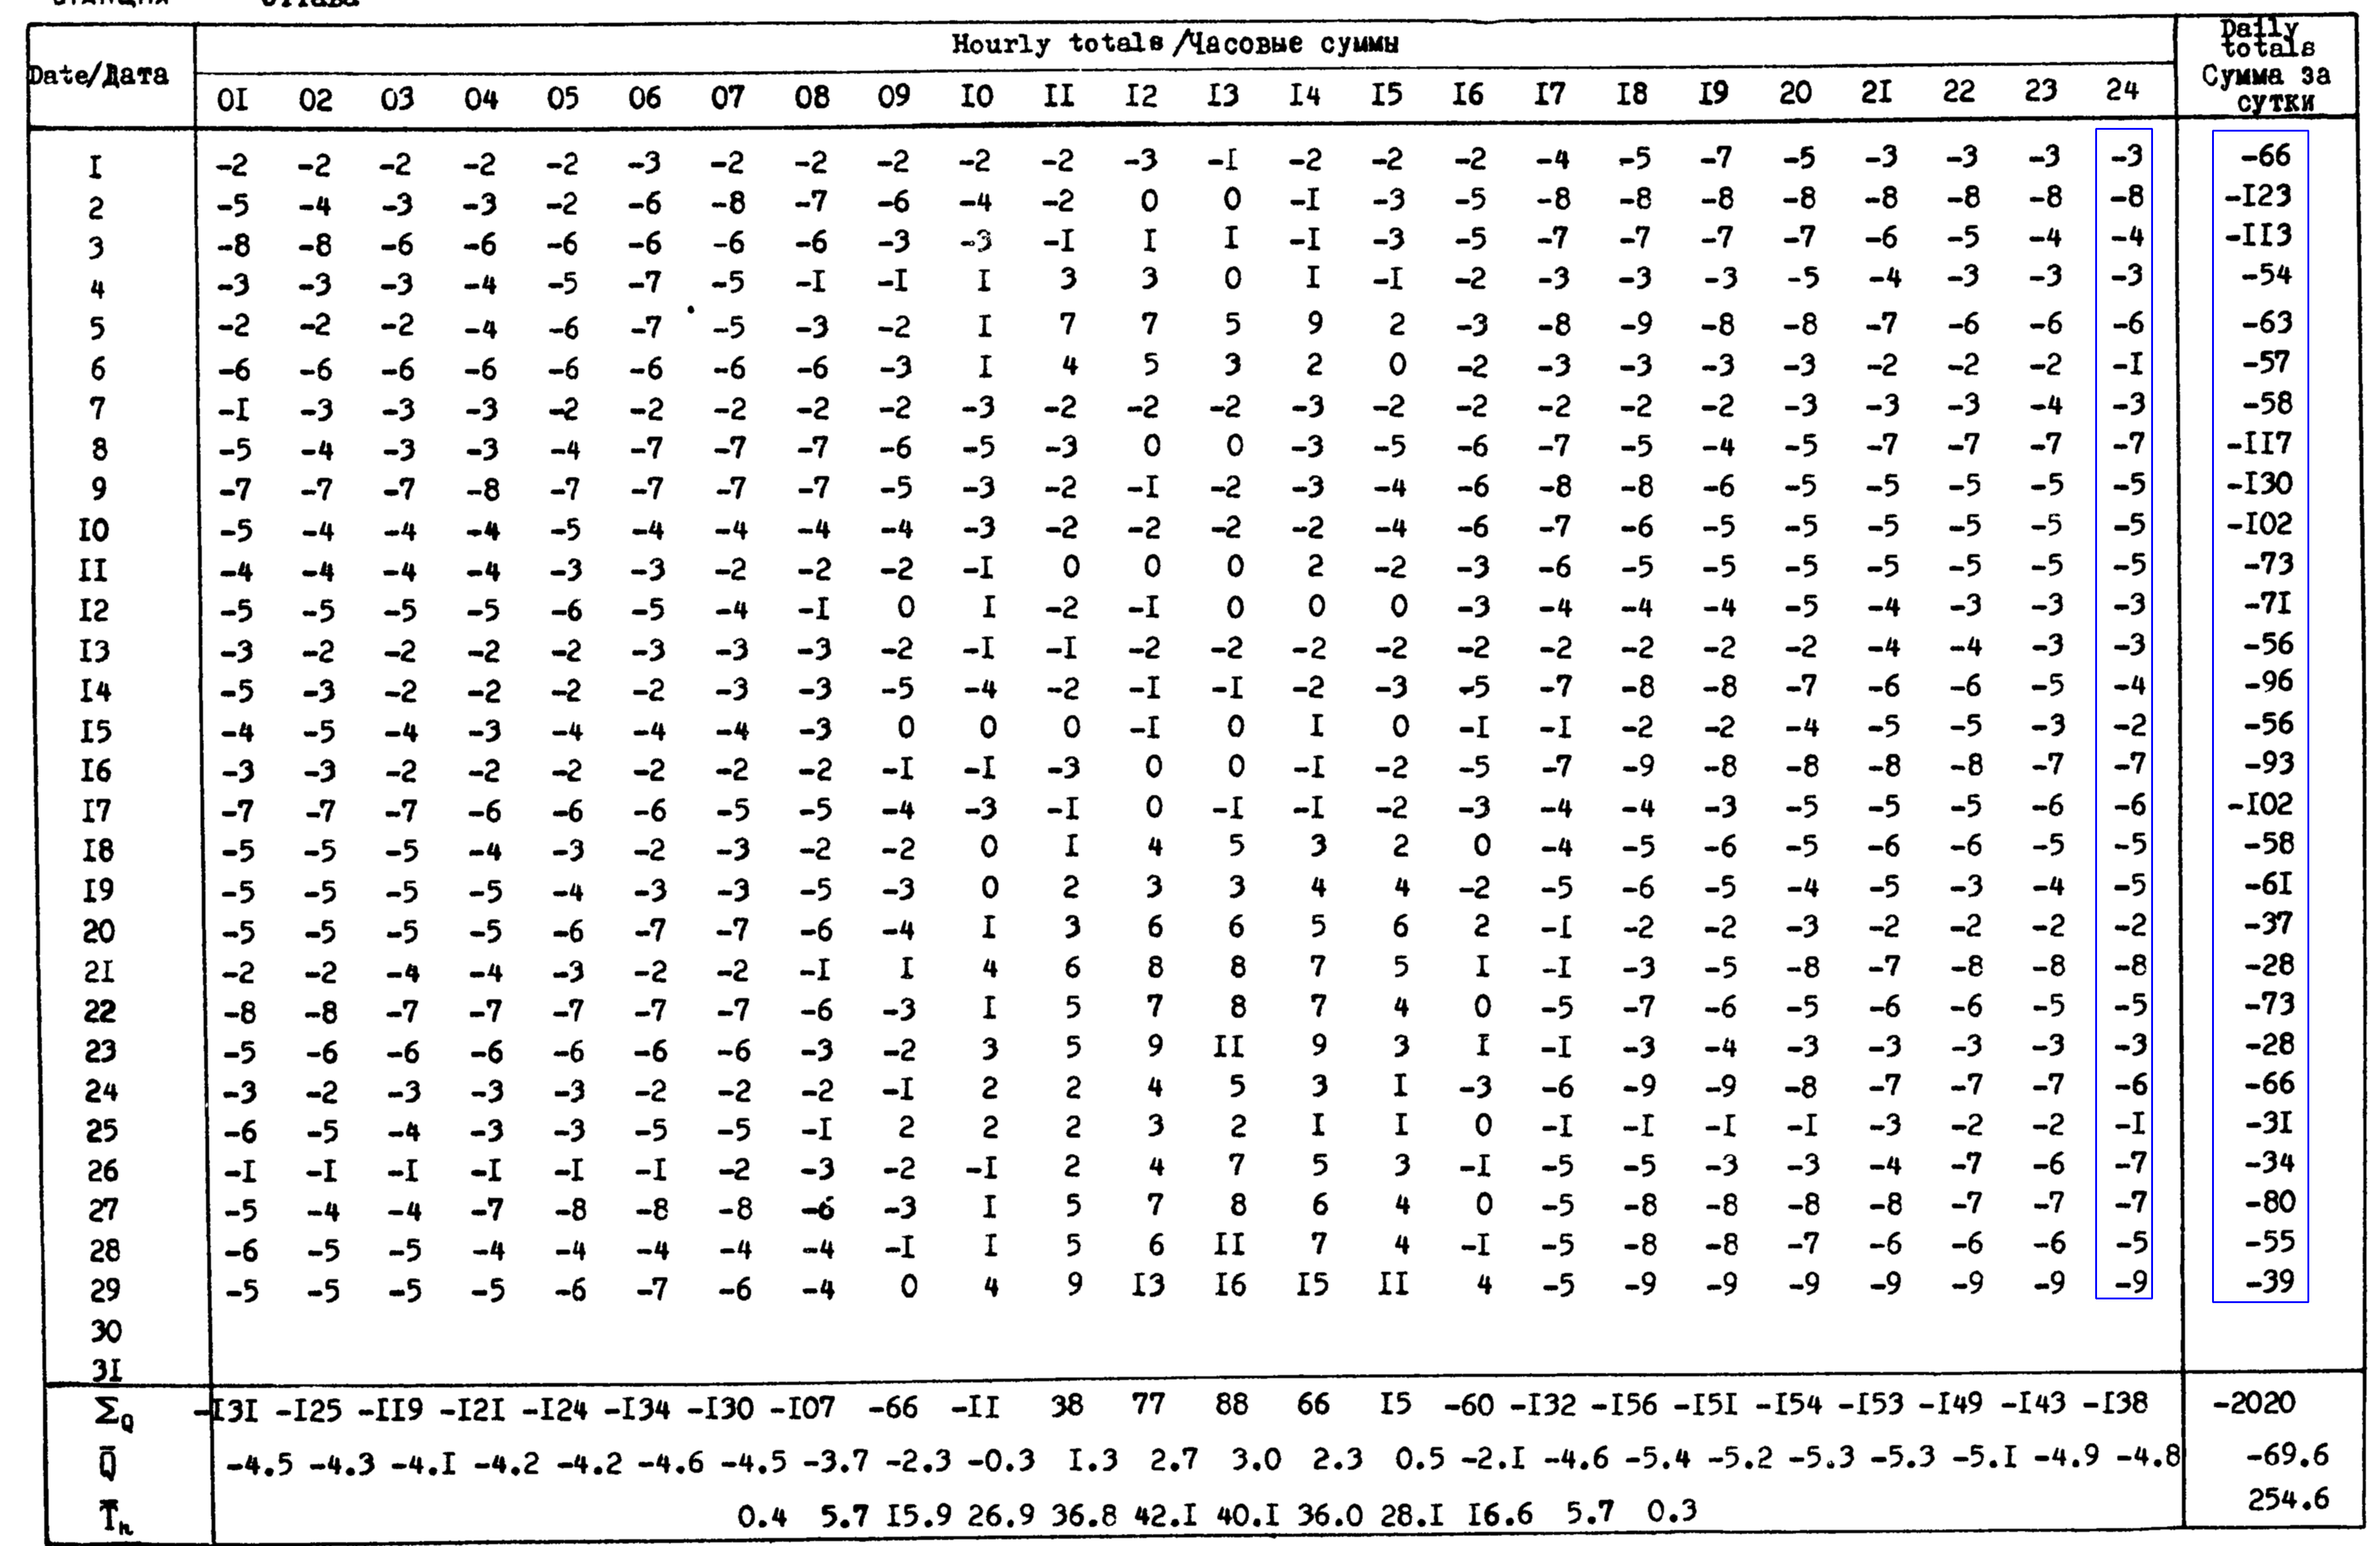

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
#[1480, 1195, 238, 2079]
#[2260, 1161, 188, 2096]

[3597, 212, 155, 1905]
[3407, 209, 91, 1902]
# Blue color in BGR
color = (255, 0, 0)
  
# Line thickness of 2 px
thickness = 2

image = "/content/drive/MyDrive/ColumnDet/images/00211991.png"
img = cv2.imread(image)

img = cv2.rectangle(img, (3597, 212), (3597+155 ,212+1905), color, thickness)
img = cv2.rectangle(img, (3407, 209), (3407+91 ,209+1902), color, thickness)


cv2_imshow(img)

In [ ]:
# install dependencies: (use cu101 because colab has CUDA 10.1)
!pip install -U torch==1.5.1+cu101 torchvision==0.6.1+cu101 -f https://download.pytorch.org/whl/torch_stable.html

# install mmcv-full thus we could use CUDA operators
!pip install mmcv-full

# install Pillow 7.0.0 back in order to avoid bug in colab
!pip install Pillow==7.0.0

!pip install mmdet

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 704.4 MB 1.2 kB/s 
     |████████████████████████████████| 6.6 MB 48.1 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0+cu111
    Uninstalling torch-1.10.0+cu111:
      Successfully uninstalled torch-1.10.0+cu111
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.11.1+cu111
    Uninstalling torchvision-0.11.1+cu111:
      Successfully uninstalled torchvision-0.11.1+cu111
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.11.0 requires torch==1.10.0, but you have torch 1.5.1+cu101 which is incompatible.
     |████████████████████████████████| 390 kB 32.1 MB/s 
     |████████████████████████████████| 185 kB 43.9 MB/s 
  Created wheel for mmcv-full: filename=mmcv_full-1.3.17-cp37-cp37

     |████████████████████████████████| 1.2 MB 27.7 MB/s 
  Created wheel for terminaltables: filename=terminaltables-3.1.0-py3-none-any.whl size=15354 sha256=aee912b9f723adfcc96c4109469cdff5dcff367165d29c584f63f8c89485b3a8
  Stored in directory: /root/.cache/pip/wheels/ba/ad/c8/2d98360791161cd3db6daf6b5e730f34021fc9367d5879f497
Successfully built terminaltables


In [ ]:
# Install mmdetection
!rm -rf mmdetection
!git clone https://github.com/open-mmlab/mmdetection.git
%cd mmdetection

!pip install -e .

Cloning into 'mmdetection'...
remote: Enumerating objects: 21578, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 21578 (delta 4), reused 8 (delta 1), pack-reused 21559
Receiving objects: 100% (21578/21578), 25.07 MiB | 28.49 MiB/s, done.
Resolving deltas: 100% (15146/15146), done.
/content/mmdetection
Obtaining file:///content/mmdetection
  Attempting uninstall: mmdet
    Found existing installation: mmdet 2.18.0
    Uninstalling mmdet-2.18.0:
      Successfully uninstalled mmdet-2.18.0
  Running setup.py develop for mmdet


In [ ]:
# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMDetection installation±
import mmdet
print(mmdet.__version__)

# Check mmcv installation
from mmcv.ops import get_compiling_cuda_version, get_compiler_version
print(get_compiling_cuda_version())
print(get_compiler_version())

1.5.1+cu101 True
2.18.0
11.1
GCC 7.5


In [ ]:
from mmcv import Config
from mmdet.apis import set_random_seed
from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.apis import train_detector, init_detector, inference_detector, show_result_pyplot
import torch 

In [ ]:
!gdown "https://drive.google.com/u/0/uc?id=1-QieHkR1Q7CXuBu4fp3rYrvDG9j26eFT"

Downloading...
From: https://drive.google.com/u/0/uc?id=1-QieHkR1Q7CXuBu4fp3rYrvDG9j26eFT
To: /content/mmdetection/epoch_36.pth
100% 664M/664M [00:04<00:00, 166MB/s]


In [ ]:
!wget http://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_x101_64x4d_fpn_1x_coco/faster_rcnn_x101_64x4d_fpn_1x_coco_20200204-833ee192.pth

--2021-11-11 16:44:08--  http://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_x101_64x4d_fpn_1x_coco/faster_rcnn_x101_64x4d_fpn_1x_coco_20200204-833ee192.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 47.252.96.15
Connecting to download.openmmlab.com (download.openmmlab.com)|47.252.96.15|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 399528659 (381M) [application/octet-stream]
Saving to: ‘faster_rcnn_x101_64x4d_fpn_1x_coco_20200204-833ee192.pth’

faster_rcnn_x101_64 100%[===================>] 381.02M  6.97MB/s    in 47s     

2021-11-11 16:44:57 (8.10 MB/s) - ‘faster_rcnn_x101_64x4d_fpn_1x_coco_20200204-833ee192.pth’ saved [399528659/399528659]



In [ ]:
import os

cfg = Config.fromfile('/content/mmdetection/configs/faster_rcnn/faster_rcnn_x101_64x4d_fpn_1x_coco.py')
cfg.dataset_type = 'CocoDataset'
cfg.classes = cfg.classes = ("column",)

PREFIX = 'threshold_inverted'
BASE_PATH = '/content/drive/MyDrive/ColumnDet'

cfg.model.roi_head.bbox_head.num_classes = 1


val_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations', with_bbox=True),
    dict(type='Resize', img_scale=(1333, 800), keep_ratio=True),
    dict(type='RandomFlip', flip_ratio=0.5),
    dict(
        type='Normalize',
        mean=[123.675, 116.28, 103.53],
        std=[58.395, 57.12, 57.375],
        to_rgb=True),
    dict(type='Pad', size_divisor=32),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_bboxes', 'gt_labels'])
]

cfg.val_pipeline = val_pipeline
cfg.data.val['pipeline'] = val_pipeline

cfg.data.train.img_prefix = PREFIX
cfg.data.train.data_root = BASE_PATH
cfg.data.train.ann_file = 'coco/train.json'
cfg.data.train.classes = cfg.classes
cfg.data.train.type = 'CocoDataset'

cfg.data.val.img_prefix = PREFIX
cfg.data.val.data_root = BASE_PATH
cfg.data.val.ann_file = 'coco/val.json'
cfg.data.val.classes = cfg.classes
cfg.data.val.type = 'CocoDataset'

cfg.data.test.img_prefix = PREFIX
cfg.data.test.data_root = BASE_PATH
cfg.data.test.ann_file = 'coco/test.json'
cfg.data.test.classes = cfg.classes
cfg.data.test.type = 'CocoDataset'

cfg.load_from = os.path.join('/content/mmdetection/faster_rcnn_x101_64x4d_fpn_1x_coco_20200204-833ee192.pth')
cfg.work_dir = os.path.join(BASE_PATH, 'workdir')

cfg.optimizer.lr = 0.001
cfg.lr_config.warmup = None
cfg.log_config.interval = 600

cfg.evaluation.interval = 3
cfg.evaluation.classwise = True

cfg.checkpoint_config.interval = 10

cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

cfg.lr_config = dict(
    warmup=None,
    warmup_iters=500,
    warmup_ratio=0.001,
    step=[8, 11],
    policy='step')


cfg.runner.max_epochs = 100
cfg.workflow = [('train', 1),('val', 1)]

cfg.data.samples_per_gpu = 1

cfg.dump(os.path.join(BASE_PATH, 'workdir',"training.py"))

print(f'Config:\n{cfg.pretty_text}')

Config:
model = dict(
    type='FasterRCNN',
    backbone=dict(
        type='ResNeXt',
        depth=101,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        frozen_stages=1,
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=True,
        style='pytorch',
        init_cfg=dict(
            type='Pretrained', checkpoint='open-mmlab://resnext101_64x4d'),
        groups=64,
        base_width=4),
    neck=dict(
        type='FPN',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        num_outs=5),
    rpn_head=dict(
        type='RPNHead',
        in_channels=256,
        feat_channels=256,
        anchor_generator=dict(
            type='AnchorGenerator',
            scales=[8],
            ratios=[0.5, 1.0, 2.0],
            strides=[4, 8, 16, 32, 64]),
        bbox_coder=dict(
            type='DeltaXYWHBBoxCoder',
            target_means=[0.0, 0.0, 0.0, 0.0],
            target_stds=[1.0, 1.0, 1.0, 1.0]),
        loss_cls=dict

In [ ]:
import mmcv
import os.path as osp
# Build dataset
datasets = [build_dataset(cfg.data.train), build_dataset(cfg.data.val)]

# Build the detector
model = build_detector( cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

print(model.CLASSES)
# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_detector(model, datasets, cfg, distributed=False, validate=False)

loading annotations into memory...
Done (t=0.47s)
creating index...
index created!
loading annotations into memory...
Done (t=0.23s)
creating index...
index created!
('column',)


2021-11-11 16:46:59,137 - mmdet - INFO - load checkpoint from local path: /content/mmdetection/faster_rcnn_x101_64x4d_fpn_1x_coco_20200204-833ee192.pth
2021-11-11 16:46:59,457 - mmdet - WARNING - The model and loaded state dict do not match exactly

size mismatch for roi_head.bbox_head.fc_cls.weight: copying a param with shape torch.Size([81, 1024]) from checkpoint, the shape in current model is torch.Size([2, 1024]).
size mismatch for roi_head.bbox_head.fc_cls.bias: copying a param with shape torch.Size([81]) from checkpoint, the shape in current model is torch.Size([2]).
size mismatch for roi_head.bbox_head.fc_reg.weight: copying a param with shape torch.Size([320, 1024]) from checkpoint, the shape in current model is torch.Size([4, 1024]).
size mismatch for roi_head.bbox_head.fc_reg.bias: copying a param with shape torch.Size([320]) from checkpoint, the shape in current model is torch.Size([4]).
2021-11-11 16:46:59,472 - mmdet - INFO - Start running, host: root@1f8299c86174, work_di

In [ ]:
from mmdet.apis import init_detector, inference_detector, show_result_pyplot
import mmcv
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
# Load model
config_file = '/content/drive/MyDrive/ColumnDet/workdir/training.py'
checkpoint_file = '/content/drive/MyDrive/ColumnDet/workdir/epoch_40.pth'
model = init_detector(config_file, checkpoint_file, device='cpu')

# Test a single image 
img = "/content/drive/MyDrive/ColumnDet/images/0008191.png"
img = cv2.imread(img)

kernel = np.ones((13, 13), np.uint8)
e = cv2.erode(img, kernel, iterations=2)
ret, th = cv2.threshold(e, 150, 255, cv2.THRESH_BINARY_INV)

e = cv2.resize(th, (1333,800))

#cv2_imshow(e)

# Run Inference
result = inference_detector(model, e)


load checkpoint from local path: /content/drive/MyDrive/ColumnDet/workdir/epoch_40.pth


/content/mmdetection/mmdet/datasets/utils.py:69: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  'data pipeline in your config file.', UserWarning)


In [ ]:
print(len(result[0]))
result[0]

10


array([[1.5673077e+02, 5.9840912e+01, 1.9776508e+02, 6.9131873e+02,
        9.9294394e-01],
       [2.8646622e+02, 5.7900818e+01, 3.2580508e+02, 6.9007336e+02,
        9.9266195e-01],
       [5.4270331e+02, 6.0465942e+01, 5.8244452e+02, 6.9273810e+02,
        9.9219608e-01],
       [6.7455457e+02, 6.1386017e+01, 7.1033752e+02, 6.9851636e+02,
        9.9206382e-01],
       [4.1525653e+02, 5.6545715e+01, 4.5421643e+02, 6.8803687e+02,
        9.9137163e-01],
       [8.0109387e+02, 6.0839813e+01, 8.3951880e+02, 6.9779431e+02,
        9.8970592e-01],
       [4.4442612e+01, 5.9715546e+01, 8.0537590e+01, 6.9351746e+02,
        9.6929026e-01],
       [9.3621234e+02, 6.1471886e+01, 9.8269208e+02, 1.1273856e+02,
        5.1403451e-01],
       [1.0679452e+03, 6.1522644e+01, 1.1153268e+03, 1.1012152e+02,
        3.2898986e-01],
       [1.1979595e+03, 6.2238770e+01, 1.2455737e+03, 1.0884407e+02,
        2.8620481e-01]], dtype=float32)

In [ ]:
with open('file.npy', mode='wb') as f:
    np.save(f, result[0])

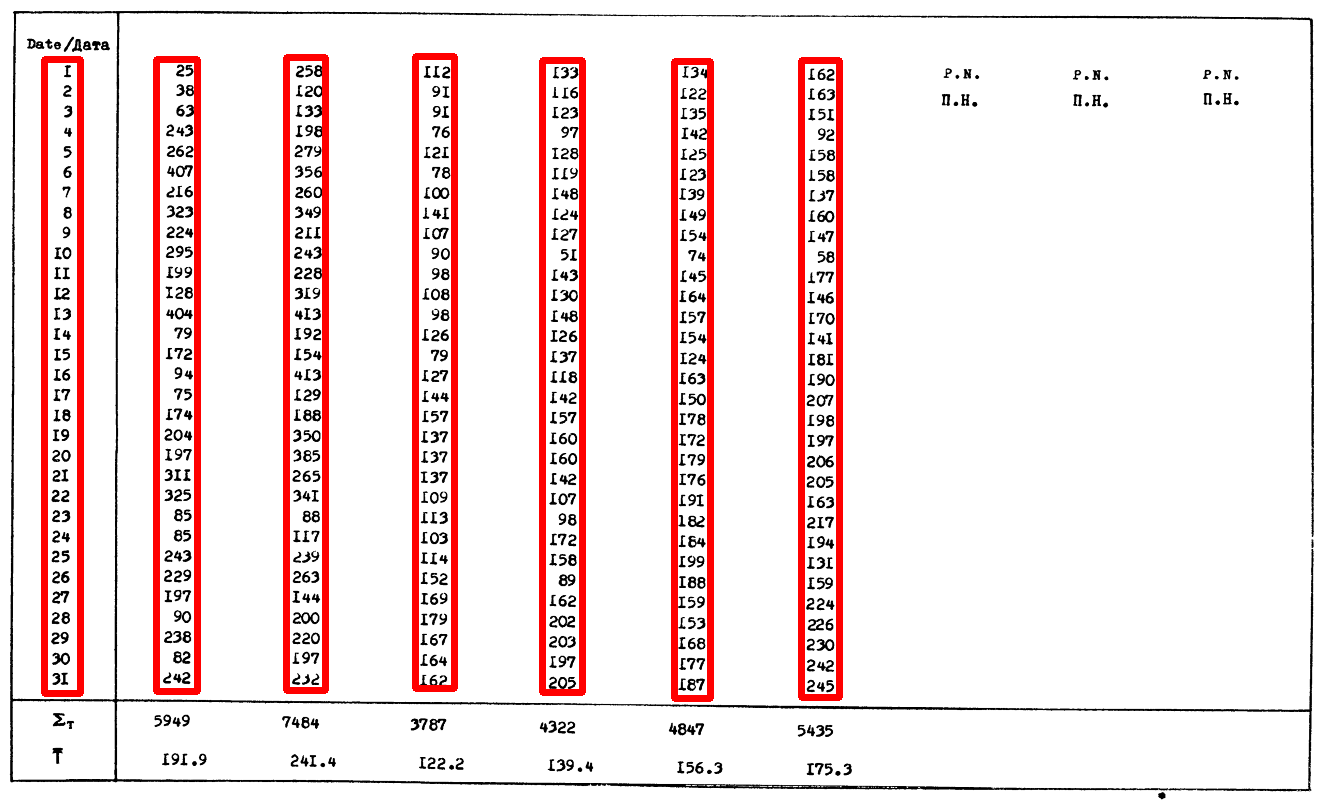

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
#[1480, 1195, 238, 2079]
#[2260, 1161, 188, 2096]
img = "/content/drive/MyDrive/ColumnDet/images/0008191.png"
img = cv2.imread(img)

img = cv2.resize(img, (1333,800))
# Blue color in BGR
color = (0, 0, 255)
  
# Line thickness of 2 px
thickness = 5

for arr in result[0]:
    if arr[-1] >= 0.6:
        img = cv2.rectangle(img, (int(arr[0]), int(arr[1])), (int(arr[2]) ,int(arr[3])), color, thickness)



cv2_imshow(img)

In [ ]:
img

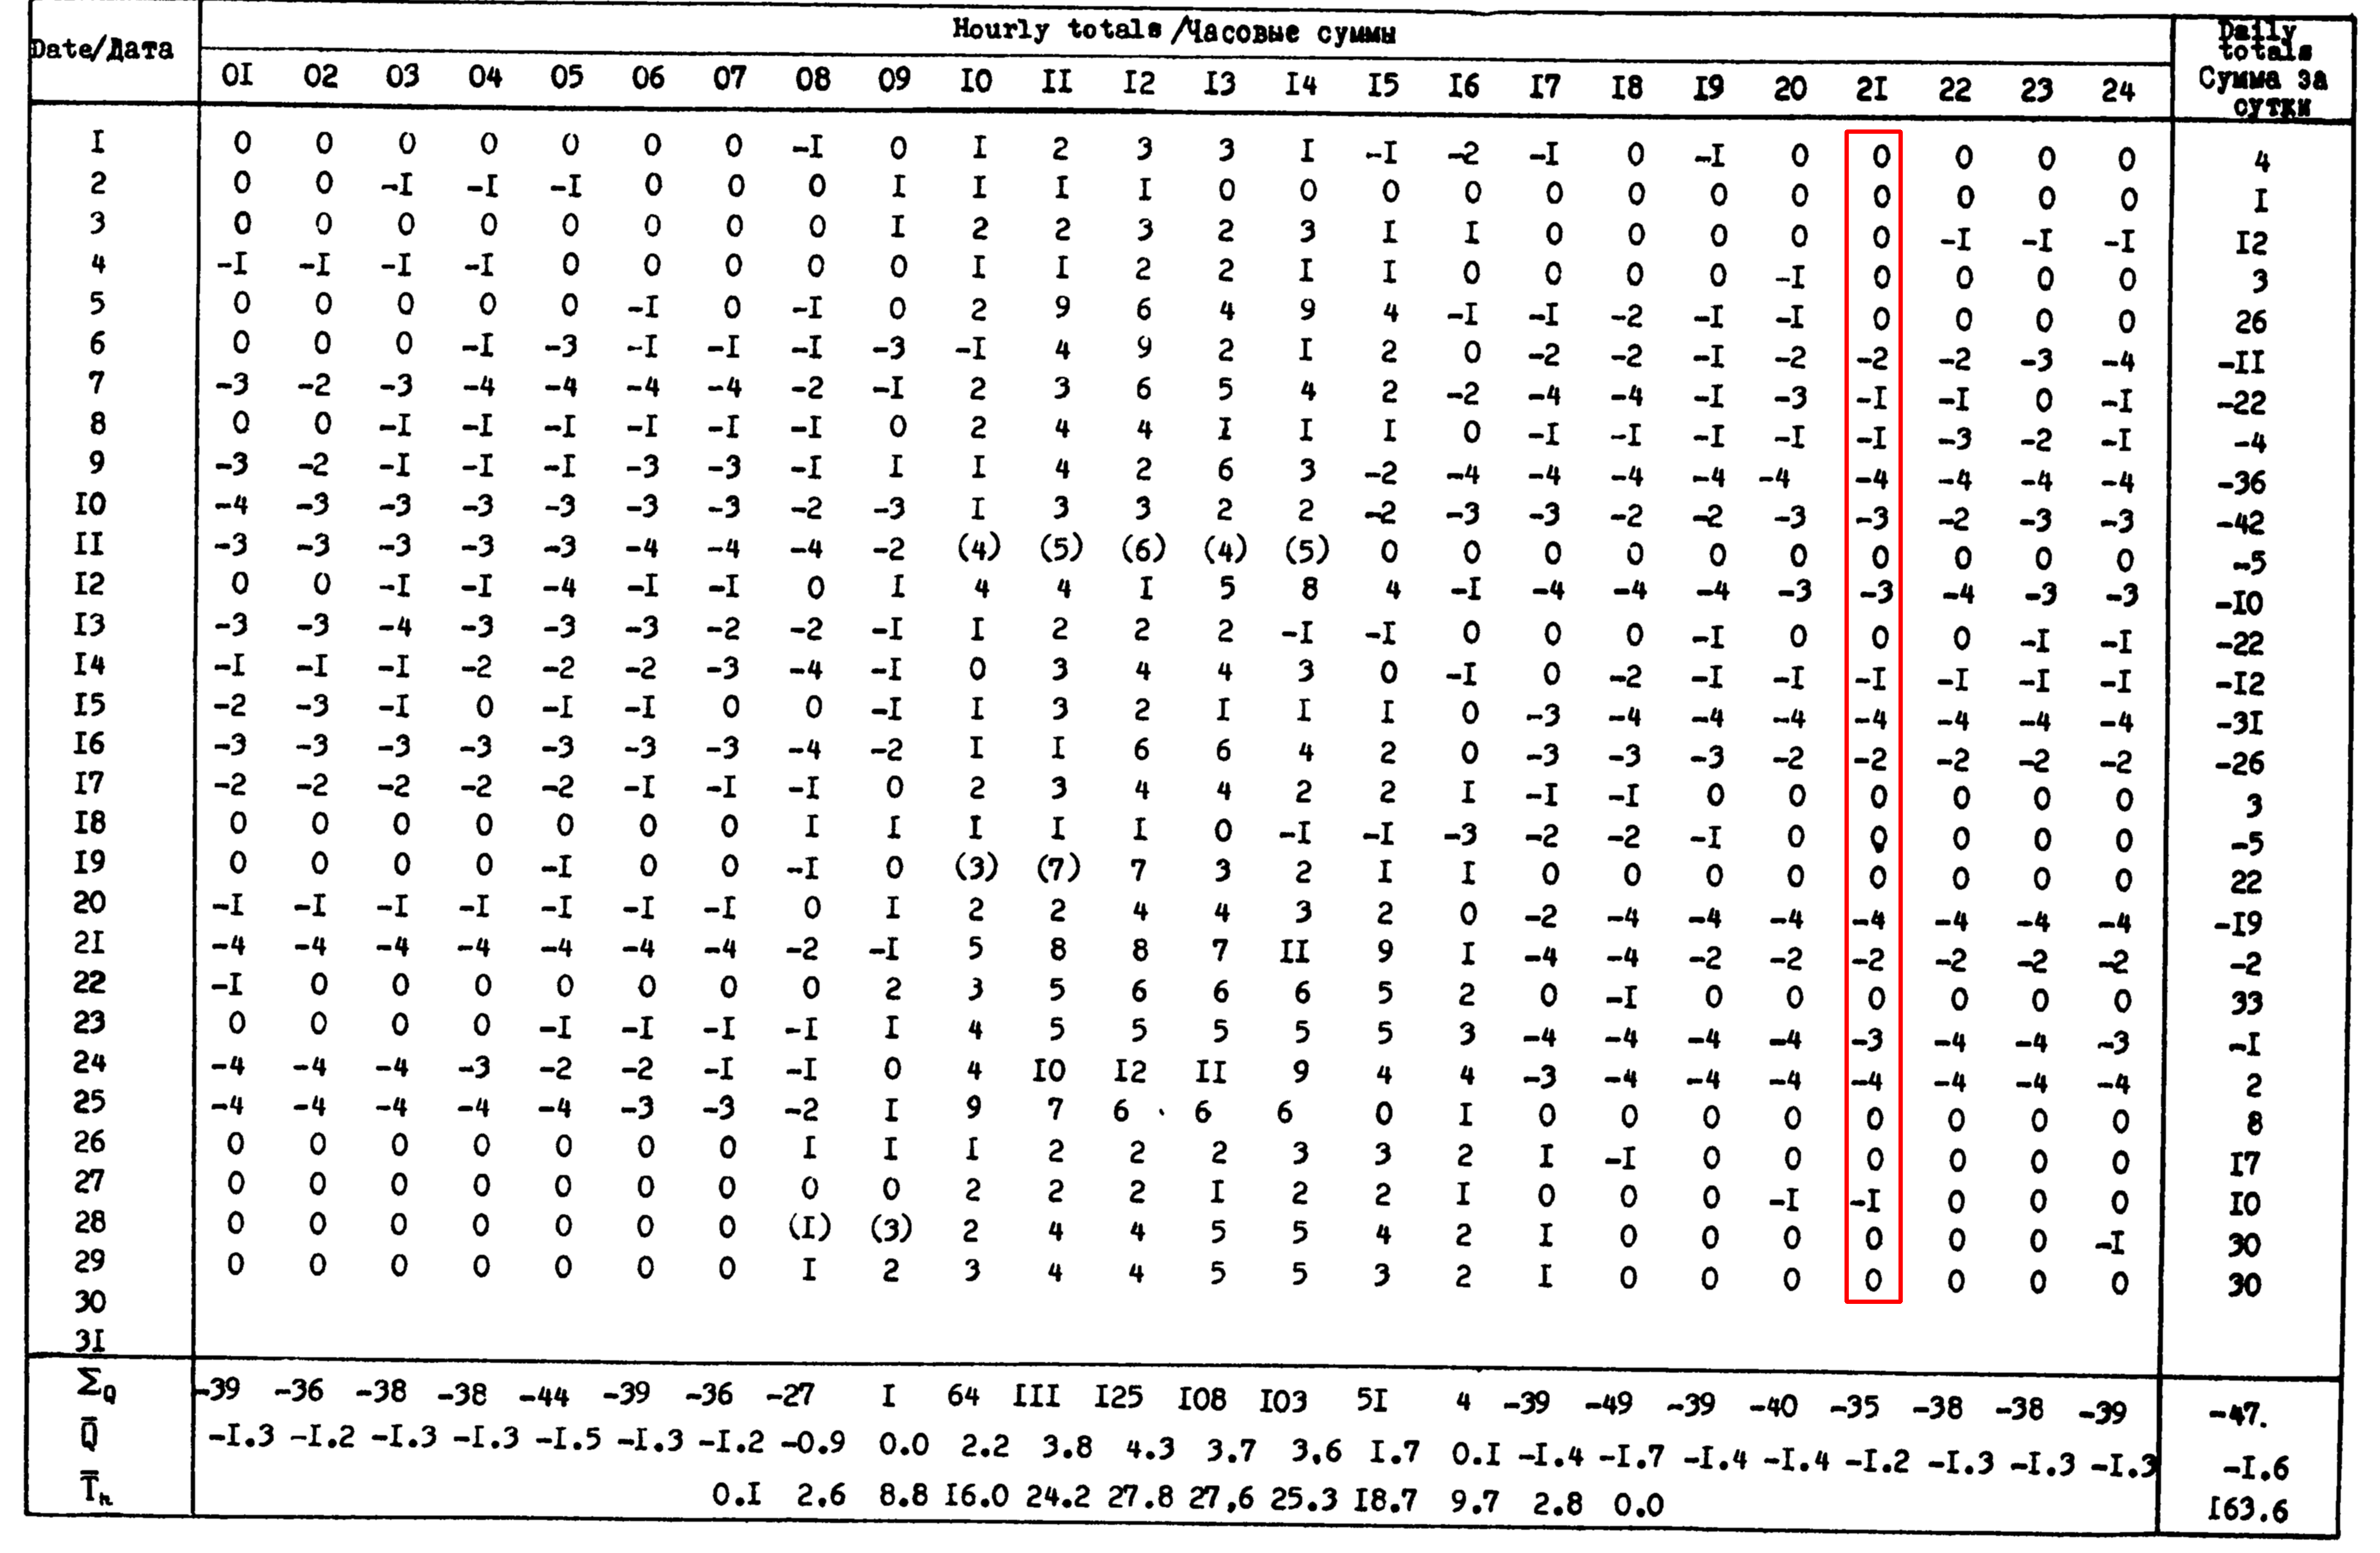

In [ ]:
img = "/content/drive/MyDrive/ColumnDet/images/00240990.png"
img = cv2.imread(img)

img = cv2.rectangle(img, (3010, 214), (3010+88 ,214+1907), color, thickness)


cv2_imshow(img)